In [33]:
import math
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def f(x):
    return 3*x**2 - 4*x +5


In [35]:
f(3.0)

20.0

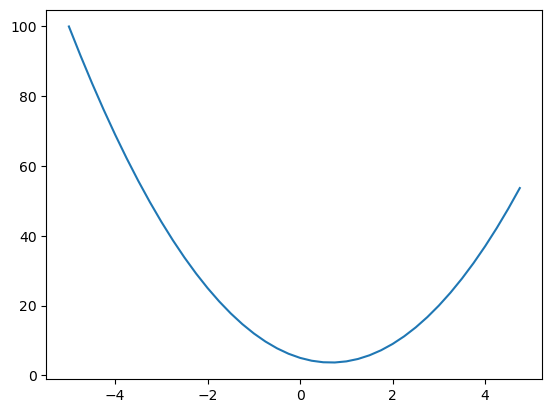

In [36]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs , ys)

If we try to evaluate the derivative , we are not going to use the mathematical derivation of finding derivative. Instead ,
<!-- we are going to use the main definition of derivative which is derivative as a limit ![alt text](image.png) -->

In [37]:
h = 0.000001
x = 2/3
((f(x+h)-f(x))/h)

2.999378523327323e-06

In [38]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [39]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c    #f(a, b, c)
a+=h
d2 = a*b+c    #f(a+h , b ,c)
print("d1" , d1)
print("d2" , d2) 
print("Slope" , (d2-d1)/h)

d1 4.0
d2 3.999699999999999
Slope -3.000000000010772


We'll be implementing a value-object type data strucuture with the idea of the main definition of differentiation to implement this

In [76]:
class Value:
    def __init__(self, data, _children = () , _op = '' , label = '' ):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda: None #by default it is a empty function (for leaf node , there is nothing to do )
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"value(data={self.data})"
    
    def __add__(self , other):
        out = Value(self.data+other.data , (self , other) , '+')
        #to automate backpropagation , we need to make the _backward function in such a way so that
        #it takes the gradient of the outs grad  and propagate it to the inputs grad(meaning - self and other)
        def _backward():
            self.grad += 1.0*out.grad     #chain rule-localD * GlobalD(out derivative) #in the form - x1w1 + x2w2 bbecause it is for addition
            other.grad += 1.0*out.grad    #chain rule - same 
        out._backward = _backward    #( take the global derivative, which is with respect to the current expression and propagate that gradient)

        return out
    
    def __mul__(self , other):
        out = Value(self.data * other.data , (self , other) , '*')
        def _backward():
            self.grad += other.data*out.grad # in the form - x1w1*x2w2
            other.grad += self.data*out.grad #same but opposite in the case of local derivative 
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t , (self , ) , 'tanh')
        def _backward() : 
            self.grad += (1-t**2)*out.grad    # local derivative - d(tanh(x)) = 1- (tanh(x))^2 , in this case = 1 - t**2  
        out._backward =  _backward 
        
        return out
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

      
a = Value(2.0 , label = 'a')
b = Value(-3.0 , label = 'b')
c = Value(10.0 , label = 'c')
e = a*b ; e.label = 'e' 
d = e + c ; d.label = 'd'
f = Value(-2.0 , label='f')
L = d*f  ; L.label = 'L'
L 



        

value(data=-8.0)

In [41]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [42]:
#This code is just for visualization purpose 


from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data , n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

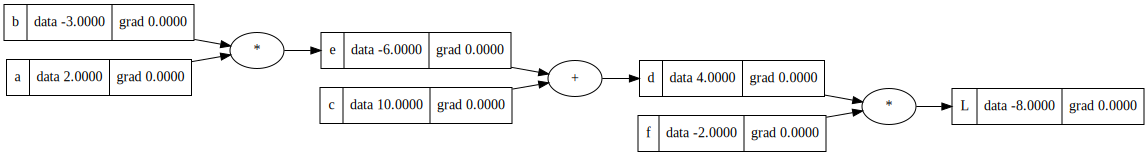

In [43]:
draw_dot(L)

Recap of What we've done so far:
- We've implemented a value-object type data structure
- Then we Make a way to forward pass the values through the network and the output of the forward pass is the value of L = -8.0000 


what we like to do next is - Backpropagation. Backpropagation is the process of finding the derivative of the loss function with respect to the weights and biases of the network.

How we do this ? 
- We'll be starting at the end - L . Then we'll find the gradient or derivative  L with respect to all the intermediate values in the network.(like - dL/dL = 1 , dL/df , dL/dd , dL/dc ,  dL/de , dL/db , dL/da)


-In the neural network setting , we'll be mainly interested in the derivative of the loss function L with respect to the weights and biases of the network.Some of the leaf nodes will be the weights and biases and some of these leaf nodes represent the data itself. We'll be interested in the derivative of the loss function with respect to these leaf nodes which represent the weights and biases  not the leaf nodes which represent the data itself.Because data is fixed but the weights and biases will be iterated on.


- To store the gradient or derivative data of the neural network in each nodes , we'll introduce a new property called grad(intialized with zero , which means 'no effect' of this current node) in the value-object type data structure. This grad property will store the derivative of the loss function with respect to the value of the node.


### So lets recap grad property of the value-object type data structure:
- grad stored the gradient or the derivative of the loss function with respect to the value of the node. (like if the node is a , then grad stores dL/da)
- grad is initialized with zero , which means 'no effect' of this current node to the loss function L if we change the value of this node.



### So lets update the weights of each nodes by doing manual Backpropagation:(starting from the end - L)

All you have to know is the local derivative of node and then backpropagate the gradient to the previous nodes.


L = d*f 
lets do for d first , 

dL/dd = ? 

derivation : (it will be f , you know <:) from the calculus class )
anyway lets derive it , 
(f(x+h) - f(x)) /h
=>((d+h)*f - d*f)/h
=>hf/h => f 
 so : dL/dd = f

also for f , 
dL/df = d




Now lets do it for dL/dc and dl/de- 
dL/dc = ?
you cannot directly derive it , you have to derive it by using the chain rule of differentiation
dL/dc = dL/dd * dd/dc

dd/dc = d/dc(c+e) = 1.0
dL/dd = f = -2.0

dL/dc = -2.0 * 1.0 = -2.0

Now , dL/de = ?
dL/de = dL/dd * dd/de

dd/de = d/de(c+e) = 1.0
dL/dd = f = -2.0

dL/de = -2.0 * 1.0 = -2.0

Now lets do it for dL/db and dL/da-
dL/da = ?
we know : dL/de = -2.0
e = a * b 
so  de/da = b = -3.0
dL/da = dL/de * de/da = -2.0 * -3.0 = 6.0

Now , dL/db = ?
we know : dL/de = -2.0
e = a * b
so de/db = a = 2.0
dL/db = dL/de * de/db = -2.0 * 2.0 = -4.0




In [46]:
#manually setting the gradient or derivatives 


# First for L 
L.grad = 1.0 

# then backpropagate - 
f.grad = 4.0000
d.grad = -2.0000

# then backpropagate-
# This is the main step , if you understand this , then you understand neural network basics 
# we need to find dL/dc and dL/de . But the problem is c or e is not directly manipulating L. It is manipulating through d and f . 
# So if you can somehow find the information about the impact of c on d and then d on L , that means you can find the impact of c directly on L.
e.grad = -2.0000
c.grad = -2.0000
# One thing we can say is - '+' node simply distribute the gradient through its children or leaf nodes(like it does in c and e) 

#Then backpropagate- 
a.grad = 6.0000
b.grad = -4.0000





## Optimization:
- Now lets see if we can nudge some leaf nodes and see if we can decrease the loss function L or if the value of loss function L goes up from -8.


### lets nudge the leaf nodes by a small amount 0.01 and see if the loss function L goes up .


In [47]:
a.data+=0.01*a.grad
b.data+=0.01*b.grad
c.data+=0.01*c.grad
f.data+=0.01*f.grad

# lets do forward pass again

e = a * b 
d = e + c 
L = d * f

print(L.data)


# the first output will be  : -7.286496


-7.286496


- So we can say that the value of L can be manipulated through backpropagation. This is the first step of something called "Optimization" in the neural network setting. We'll be updating the weights and biases of the network in the direction of the negative gradient of the loss function L. This is the idea of the optimization algorithm called "Gradient Descent".


- But why we are taking the leaf nodes only? Because we have some form of control over the leaf nodes. we can change and know for a fact that the loss function L will change.
But we don't have control over the intermediate nodes.

we've set the value of grads manually , now lets check them using the definition of differentiation and see if we are correct or not.(h = 0.0001)
You should check for each of the values - l , d , f , c , e , a , b

In [48]:
def lol():   #this function is created so that we don't mess up the other local variable . Just for testing purpose
    h = 0.0001

    a = Value(2.0 , label = 'a')
    b = Value(-3.0 , label = 'b')
    c = Value(10.0 , label = 'c')
    e = a*b ; e.label = 'e' 
    d = e + c ; d.label = 'd'
    f = Value(-2.0 , label='f')
    L = d*f  ; L.label = 'L'
    L1 = L.data

    a = Value(2.0 , label = 'a')
    b = Value(-3.0 , label = 'b')
    c = Value(10.0 , label = 'c')
    e = a*b ; e.label = 'e' 
    d = e + c ; d.label = 'd'
    f = Value(-2.0 , label='f')
    L = d*f  ; L.label = 'L'
    L2 = L.data+h
    print((L2-L1)/h)
lol()

0.9999999999976694


## Manual backpropagation Example : A Neuron or from a perspective of a perceptron

![alt text](image-1.png)



For activation function , we will use the tanh activation function. 



In [ ]:
plt.plot(np.arange(-5, 5 , 0.2),np.tanh(np.arange(-5, 5 , 0.2)))

plt.grid() ; 

In [79]:
#lets create a simple network of two input and one output with an activation function tanh

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


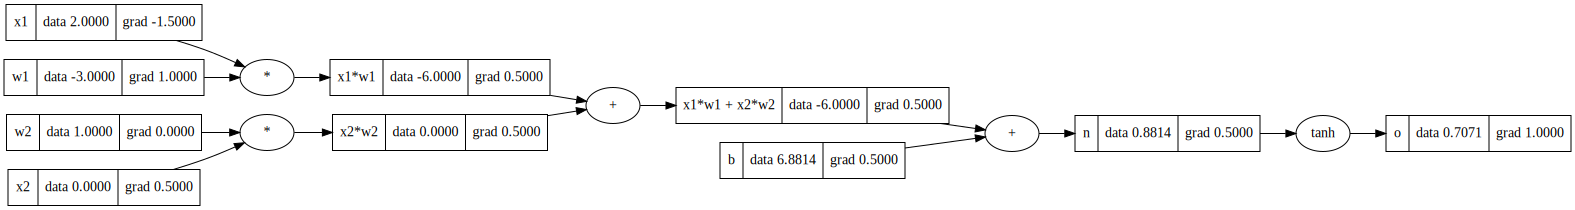

In [82]:
draw_dot(o)

In [ ]:
#do not run the below  two cells(those two are partially automated). Because Now we've already implemented the fully automated backpropagation by implementing a 
#function backward(self) in the Value class hiding the automating process.

o.backward()

In [73]:
#This is Automatic Backpropagation . First you should check the manual backpropagation for this Neural network and then try this 

#Automatic Backpropagation by calling the _backward function that we defined:

o.grad = 1.0 #this should be set as base case to 1.0. Because initially the grad for o or the final output is set to zero in the class.If
            #we do not set this to 1.o , 0 will be backpropagated to every grad , making every grad to 0. 
# Call the backward method on output node
o._backward()

In [74]:
# Now we need to call backward on all nodes in reverse topological order
n._backward()

b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()


## Now lets do manual backpropagation again for this network and update each of the gradient values of the nodes. We will again use the concept of local derivatives and chain rule of differentiation again.

### So before begin , some important notes : 
- in the neural network setting , we'll be really interested in the derivative of the weights(w1, w2) and bias(b) not the derivative of x1 , x2. because in the optimization stage , we'll changing these weights and biases to minimize the loss function L , not the input data x1 , x2. So we'll be interested in the derivative of the loss function L with respect to the weights and biases of the network.

- Here we are having only one neuron , but typically in a neural network , there will be many neurons and many layers connected with each other.


### Manual Backpropagation
**Lets start with the end - o** 
- we always know the gradient of the loss function with respect to o , which is 1.0 <br>
**do/do** = 1.0

 **Then backpropagate through tanh.**
To backpropagate through tanh , we need to know the local derivative of tanh.
tanh(x) = (e^x - e^-x) / (e^x + e^-x)
=> dtanh(x)/dx = 1 - tanh(x)^2

o = tanh(n)
do/dn = 1 - tanh(n)^2 = 1 - o^2 

we know , o.data = .7071
=> do/dn = 1 - .7071^2 = 1 - .5 = .5

so the local derivative of tanh is .5

**Then backpropagate** 
'+' is going to distribute the gradient to both the inputs.
so do/d(x1w1 + x2w2) = 0.5
and do/d(b) = 0.5

**then backpropagate**
again '+' is going to distribute the gradient to both the inputs.
so do/d(x1w1) = 0.5
and do/d(x2w2) = 0.5

**Then backpropagate**
do/dx1 = do/dx1w1 * dx1w1/dx1 = .5*w1 = .5*-3 = -1.5
do/dw1 = do/dx1w1 * dx1w1/dw1 = .5*x2= 1.0

do/dx2 = do/dx2w2 * dx2w2/dx2 = .5*w2 = .5*1 = .5
do/dw2 = do/dx2w2 * dx2w2/dw2 = .5*0 = 0








In [ ]:
#setting the gradient values from manual backpropagation 
o.grad = 1.0

In [ ]:
#then backpropagate
n.grad = 0.5

In [ ]:
#then backpropagate 
x1w1x2w2.grad=.5
b.grad = .5


In [ ]:
#then backpropagate
x1w1.grad = .5
x2w2.grad = .5

In [ ]:
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad

In [ ]:
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad